## Objective
- see whether there are any informative clusters present in our application_train data

#### Note:
- this cell below is also replicated in lib/unsupervised/clustering.py

In [1]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from plotnine import *
import pandas as pd
from sklearn.base import clone
from sklearn.preprocessing import OneHotEncoder


RANDOM_STATE = 314

class Clustering(object):
    #TODO: make safer w a primary key
    def __init__(self, X):
        """
        :param X: pandas dataframe or all features to be clustered on
        """
        self.X = X

    def elbow(self, model, wcss_func, max_n_clusters=12):
        """
        :param model: ex KMeans (before function called)
        :param wcss_func: (model, X, n_clusters) -> wcss
            model: ex KMeans (before function called)
        :param max_n_clusters:  int
        :return: None
        """
        wcss = []
        for i in range(1, max_n_clusters):
            wcss.append(wcss_func(model, self.X, i))

        elbow_df = pd.DataFrame({"n_clusters":range(1, max_n_clusters),
                                 "wcss": wcss})

        self.elbow_plot = ggplot(elbow_df, aes("n_clusters", wcss)) +\
            geom_point() +\
            geom_line()

        print(self.elbow_plot)

    def train_model_and_one_hot_training_data(self, model):
        """
        :param model: after function called (ex Kmeans(n_clusters=4))
        :return: None
        """
        self.model = model.fit(self.X)
        self.train_clusters = pd.DataFrame(
            {"train_row": range(self.X.shape[0]),
             "cluster": self.model.predict(self.X)})
        self.train_cluster_count_plot = ggplot(self.train_clusters, aes("cluster")) +\
            geom_bar()
        print(self.train_cluster_count_plot)
        self.one_hot_clusterer = OneHotEncoder()
        self.one_hotted_train_data = pd.DataFrame(
            self.one_hot_clusterer.fit_transform(self.train_clusters[["cluster"]]).toarray())
        assert self.X.shape[0] == self.one_hotted_train_data.shape[0], "shape if off"
        self.X_w_one_hots = self.X.join(self.one_hotted_train_data)

    def predict_new_clusters(self, new_X):
        """
        Important to have for testing data
        :param model: after function called (ex Kmeans(n_clusters=4))
        :return: (clusters, onehotted
        """
        if self.model is None:
            print("you need to train 1st")
        else:
            new_clusters = self.model.predict(new_X)
            new_onehots = self.one_hot_clusterer.transform(new_clusters.reshape(-1,1))
            return new_clusters, new_onehots

    def view_2d_pca_projection_of_training_data(self, n_components="ncols"):
        if n_components == "ncols":
            n_components = self.X.shape[1]
        self.pca = PCA(n_components=n_components)
        self.pcs = self.pca.fit_transform(self.X)
        print(f"explained variance ratio: {self.pca.explained_variance_ratio_}")
        pc_df = pd.DataFrame(
            {"pc1": self.pcs[:,0],
             "pc2": self.pcs[:,1]}
        ).assign(cluster=self.train_clusters["cluster"].astype(str))
        p = ggplot(pc_df, aes("pc1", "pc2", fill="cluster")) +\
            geom_point()
        print(p)

    def check_model_assumptions(self):
        """
        implement!
        for all children of this class
        :return:
        """
        pass






def kmeans_wcss(model, X, n_clusters):
    """
    references: https://medium.com/@iSunilSV/data-science-python-k-means-clustering-eed68b490e02
    :param model: pre function call
    :param X:
    :param n_clusters: int
    :return: float wcss
    """
    kmeans = model(n_clusters=n_clusters, random_state=RANDOM_STATE)
    kmeans.fit(X)
    return kmeans.inertia_



class KmeansClustering(Clustering):

    def __init__(self, X):
        Clustering.__init__(self, X)

    def elbow(self, max_n_clusters=12):
        Clustering.elbow(self, KMeans, kmeans_wcss, 12)

    def train_model_and_one_hot_training_data(self, num_clusters):
        kmeans = KMeans(n_clusters=num_clusters,
                            init= 'k-means++', # smart way of selecting initial clusters to speed up the process
                            max_iter = 300,
                            n_init = 10, # num centroid seeds
                            random_state = RANDOM_STATE)
        Clustering.train_model_and_one_hot_training_data(self, kmeans)

    def check_variance_per_assigned_cluster(self):
        print("\n\n\nhere are the variances per assigned cluster")
        X_w_clusters = self.X.copy()
#         import ipdb; ipdb.set_trace()
        X_w_clusters["cluster"] = self.train_clusters["cluster"]
        for clust in self.train_clusters['cluster'].unique():
            this_clust_df = X_w_clusters[X_w_clusters.cluster == clust]
            clust_variance = this_clust_df.iloc[:, :-1].var(axis=0)
            print(f"cluster: {clust} \ncluster variance: \n{clust_variance}")

    def check_cluster_sizes_vs_hclust(self):
        print(f"here is the cluster sizes we're guessing w kmeans: {self.train_cluster_count_plot}")
        hclust = AgglomerativeClustering(n_clusters=len(self.train_clusters["cluster"].unique()))
        hclust.fit(self.X)
        hclust_clusters = pd.DataFrame(
            {"train_row": range(self.X.shape[0]),
             "cluster": hclust.predict(self.X)})
        hclust_cluster_count_plot = ggplot(hclust_clusters, aes("cluster")) + \
                                        geom_bar()
        print(hclust_cluster_count_plot)




    def check_model_assumptions(self):
        """
        resources: http://varianceexplained.org/r/kmeans-free-lunch/
        :return:
        """
        if self.model is None:
            print("train model 1st")
        else:
            self.check_variance_per_assigned_cluster()
            self.view_2d_pca_projection_of_training_data()
#             self.check_cluster_sizes_vs_hclust() # little slow, can probably tune to speed it up


In [2]:
import os
from lib.operational.read_write_helpers import ReadWriteData
from sklearn.model_selection import train_test_split
import matplotlib
%matplotlib inline

os.getenv("PYTHONPATH")

/Users/bryparker/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


'/Users/bryparker/Documents/projects/mmf/credit_risk:'

In [3]:
conn = ReadWriteData()
conn.query_psql_table("select count(*) from application_train")

,count
0,307511


In [4]:
conn.query_psql_table('select sum("TARGET") from application_train')

,sum
0,24825.0


- we have quite a few so lets sample
- notice bc were using a db we can do this randomly (or could even filter for our specific purposes)
    - ex: you're trying build a music recommendation engine and have too much data to fit into ram
    - using csvs you can grab nrows of songs
    - but using a db you can handle more data, and can selectively filter to better songs if you need to filter down
        - for example if you're developing some unsupervised features per song
        - as always be careful of bias though

In [5]:
try:
    conn.query_psql_table("set seed to 0.123")
except Exception as error:
    print(error) # ignore this erorr (This result object does not return rows. It has been closed automatically.)

app = conn.query_psql_table("select * from application_train where random() < .33")

# can also run below if the db is giving issues / aren't using one
# DATA_DIR = "./credit_risk/data/original_data"
# app = pd.read_csv(DATA_DIR + "/application_train.csv")
train, test = train_test_split(app, random_state=RANDOM_STATE)

print(train.shape)
print(test.shape)
print(app.shape)

train.head()

This result object does not return rows. It has been closed automatically.
(75870, 123)
(25291, 123)
(101161, 123)


,index,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
14429,44098,151082,0,Cash loans,F,Y,Y,2,382500.0,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
59528,180701,309416,0,Revolving loans,F,N,Y,1,40500.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
34728,105812,222779,0,Cash loans,F,N,Y,0,90000.0,284400.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,0.0
29491,89908,204395,0,Cash loans,M,Y,Y,0,193500.0,825588.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
40949,124483,244360,0,Cash loans,F,Y,N,0,180000.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [6]:
X_train = train[["AMT_INCOME_TOTAL", "AMT_CREDIT"]]
X_test = test[["AMT_INCOME_TOTAL", "AMT_CREDIT"]]

clustering = KmeansClustering(X_train)

/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


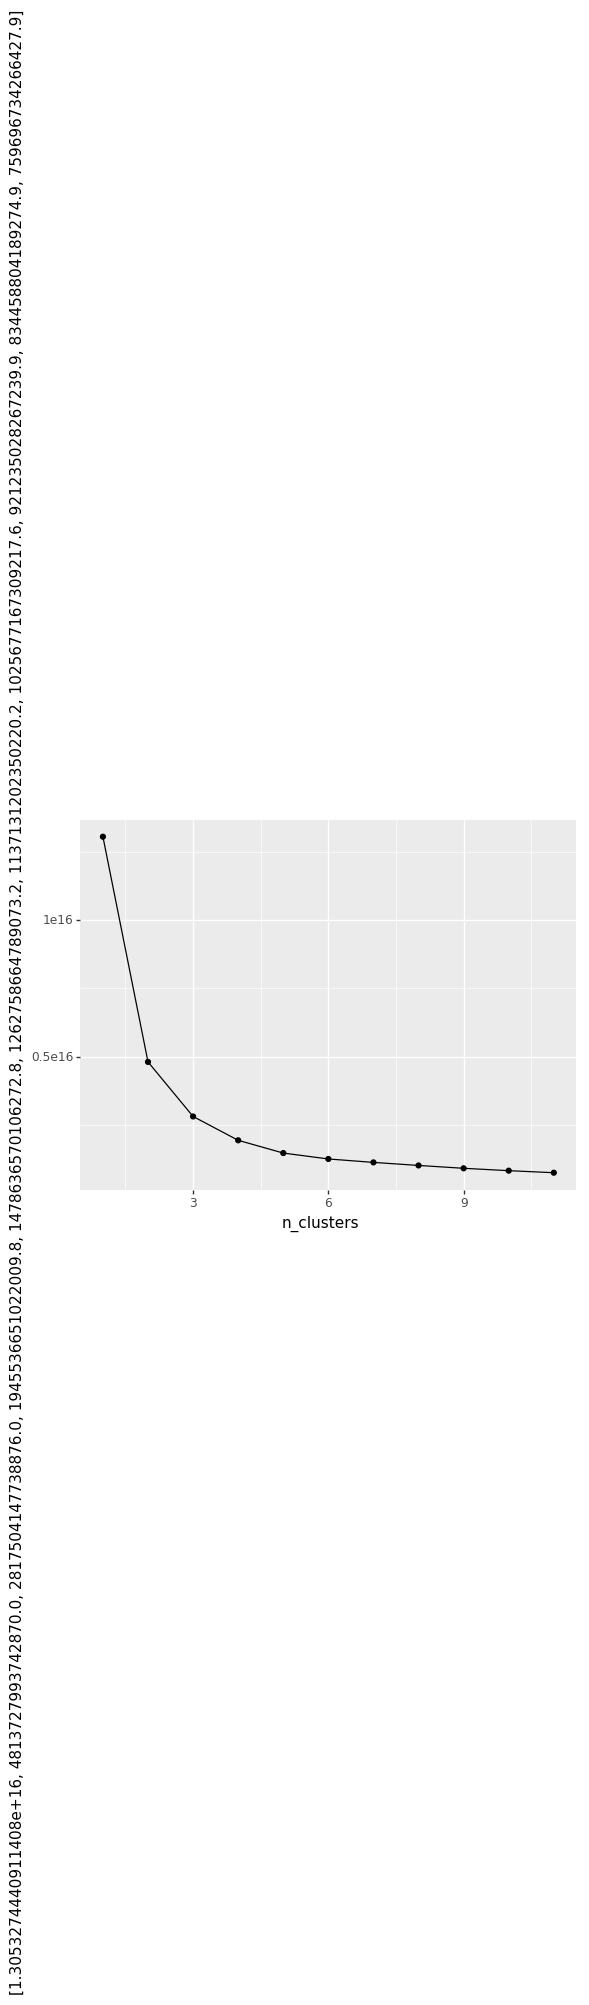

<ggplot: (-9223372029316199964)>


In [7]:
clustering.elbow()

/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/plotnine/positions/position.py:188: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  intervals = data[xminmax].drop_duplicates().as_matrix().flatten()


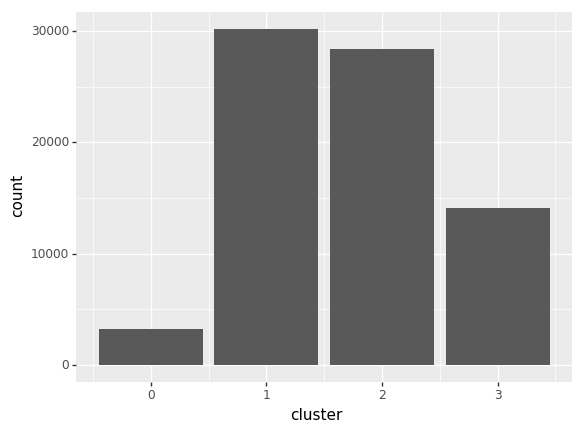

<ggplot: (7549069246)>


In [8]:
clustering.train_model_and_one_hot_training_data(4)




here are the variances per assigned cluster
cluster: 2 
cluster variance: 
AMT_INCOME_TOTAL    1.212283e+10
AMT_CREDIT          1.618633e+11
dtype: float64
cluster: 1 
cluster variance: 
AMT_INCOME_TOTAL    1.081865e+10
AMT_CREDIT          1.614589e+11
dtype: float64
cluster: 0 
cluster variance: 
AMT_INCOME_TOTAL    1.165559e+10
AMT_CREDIT          1.473055e+11
dtype: float64
cluster: 3 
cluster variance: 
AMT_INCOME_TOTAL    8.864742e+09
AMT_CREDIT          1.617882e+11
dtype: float64
explained variance ratio: [0.94591114 0.05408886]


/Users/bryparker/anaconda3/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


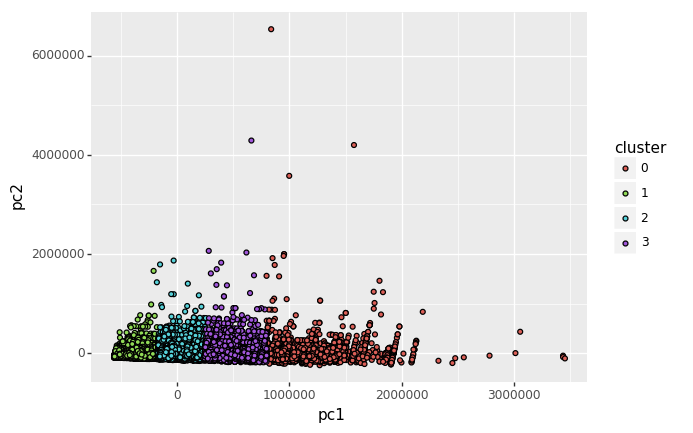

<ggplot: (-9223372029312202194)>


In [9]:
clustering.check_model_assumptions()

#### how clusters were assigned in original data

/Users/bryparker/anaconda3/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


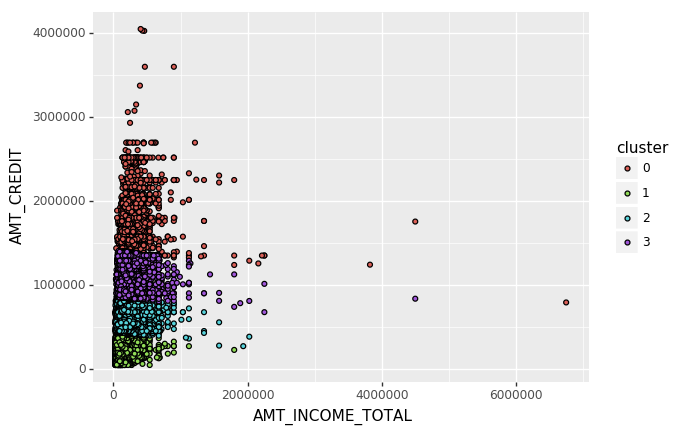

<ggplot: (-9223372029312389316)>


In [10]:
train_w_clusters = train.assign(cluster=clustering.train_clusters["cluster"].values.astype(str))

p = (ggplot(
#     train.assign(cluster=clustering.train_clusters["cluster"].astype(str)), #breaks
    train_w_clusters, 
    aes("AMT_INCOME_TOTAL", "AMT_CREDIT", fill="cluster")) +
    geom_point())
print(p)

- notice the spherical variance assumption coming into play here
    - because the variance is so wide for the highest credit cluster the variance is very wide along the income axis too
    - see the furthest income point is in the top cluster

#### How robust is our unsupervised model?

/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/bryparker/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


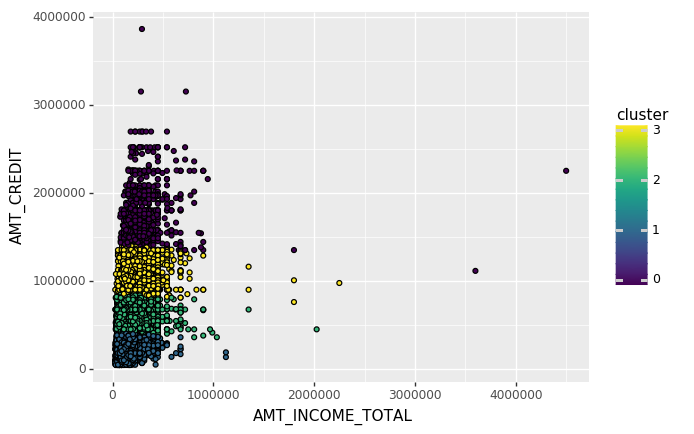

<ggplot: (7541329577)>


In [11]:
test_w_clusters = test.assign(
    cluster = clustering.predict_new_clusters(X_test)[0])

p = (ggplot(
#     train.assign(cluster=clustering.train_clusters["cluster"].astype(str)), #breaks
    test_w_clusters, 
    aes("AMT_INCOME_TOTAL", "AMT_CREDIT", fill="cluster")) +
    geom_point())
print(p)

very similar distributoin and assignments

### target distributions per cluster

In [12]:
test_counts_per_clust = test_w_clusters.groupby("cluster").agg({"TARGET": ["size", "sum"]})
train_counts_per_clust = train_w_clusters.groupby("cluster").agg({"TARGET": ["size", "sum"]})

In [13]:
train_counts_per_clust.assign(prop = train_counts_per_clust.TARGET['sum'] / train_counts_per_clust.TARGET['size'])

TARGET            prop
          size   sum          
cluster                       
0         3264   161  0.049326
1        30151  2513  0.083347
2        28384  2586  0.091108
3        14071   915  0.065027

In [14]:
test_counts_per_clust.assign(prop = test_counts_per_clust.TARGET['sum'] / test_counts_per_clust.TARGET['size'])

TARGET           prop
          size  sum          
cluster                      
0         1104   49  0.044384
1        10105  816  0.080752
2         9386  896  0.095461
3         4696  276  0.058773

### Exercise: Do better, and then model
- include more features
    - pca will be more handy here to consider model assumptions
- preprocess features better
    - should you be standardizing? how would this affect model assumptions?
        - how would this affect your ability to QA? to report to stake holders?
    - consider filtering out some outliers? how would this affect model assumptions? how would this affect the final model?
- consider using different clustering approaches
- build out a simple model, unsupervised features, as well as some features from the original data
- the way you can measure whether you've done better is whether your unsupervised approach gives you better results on the testing set
    - keep in mind though these results will be biased if you use the testing set too rigourously 
        - overfitting to it
    - which is why we have another testing set

In [15]:
X_train_one_hot = clustering.one_hotted_train_data
X_test_one_hot = pd.DataFrame(clustering.predict_new_clusters(X_test)[1].toarray())

In [16]:
X_train_one_hot.head()

,0,1,2,3
0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0


In [17]:
X_test_one_hot[:3]

,0,1,2,3
0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0
